# Day 4

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import numpy as np

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화

    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
    
class 신경망:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def softmax(z):
    exp_z = np.exp(z - z.max(axis=1, keepdims=True)) # 양수화: exp(z) > 0
    # 양수화된 값들을 전체 합계로 나누면, 합이 1.0인 확률 분포가 됨
    return exp_z / exp_z.sum(axis=1, keepdims=True)

## 손실함수

,w,b,MSE
0,-1.000,1.000,36.279
1,1.000,0.000,1.028
2,1.003,-0.063,1.024
3,1.003,-0.063,1.024


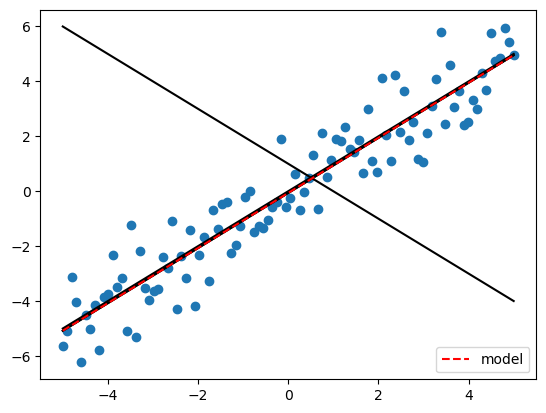

In [6]:
from sklearn.linear_model import LinearRegression

xs = np.linspace(-5, 5, 100)
noise = np.random.default_rng(seed=4).normal(0, 1, size=xs.shape)
ys = xs + noise

# 선형모형
f = lambda x, w, b: w * x + b
params = []
params.append(np.array([-1.0, 1.])) # 초기값
params.append(np.array([1.0, 0.0])) # DGP

data = xs.reshape(-1, 1); target = ys
linreg = LinearRegression().fit(data, target)
# 알고리즘의 결과
w = linreg.coef_; b = linreg.intercept_
params.append(np.append(w, b))
assert np.allclose(f(xs, w, b), linreg.predict(data))
# 정규 방정식
X = np.vstack([xs, np.ones_like(xs)]).T # 디자인 행렬
최적해 = np.linalg.inv(X.T @ X) @ X.T @ ys # 정규방정식: (X^T X)^(-1) X^T y
params.append(최적해)
assert np.allclose(최적해, np.append(w, b))

평균제곱오차 = lambda y_true, y_pred: np.mean((y_true - y_pred) ** 2)
scores = []
for w, b in params:
    y_pred = f(xs, w, b)
    scores.append(평균제곱오차(ys, y_pred))

display(pd.DataFrame(params, columns=['w', 'b']).assign(MSE=scores).round(3))

plt.scatter(xs, ys)
for w, b in params:
    plt.plot(xs, f(xs, w, b), 'k')
plt.plot(xs, linreg.predict(data), 'r--', label='model')
plt.legend()
plt.show()

## MNIST

In [7]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

In [8]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    X = images.astype(np.float32)
    X = X.reshape(-1, 28 * 28)
    X = X / 255.0
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)
print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(train_data.min(), 0.0)
assert np.isclose(test_data.max(), 1.0) and np.isclose(test_data.min(), 0.0)

(60000, 784) (10000, 784)


In [13]:
model = 신경망()
model.add(다중퍼셉트론(28*28, 50, sigmoid))
model.add(다중퍼셉트론(50, 100, sigmoid))
model.add(다중퍼셉트론(100, 10, softmax))

outputs = model(test_data)
assert np.allclose(outputs.sum(axis=1), 1.0)  # softmax(logits)
print(outputs.shape)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

display(pd.DataFrame(outputs).assign(pred=y_pred, target=test_target)[:5].round(3))

(10000, 10)
정확도: 10.54%


,0,1,2,3,4,5,6,7,8,9,pred,target
0,0.997,0.000,0.0,0.002,0.000,0.000,0.000,0.0,0.0,0.000,0,7
1,0.991,0.000,0.0,0.001,0.000,0.000,0.003,0.0,0.0,0.005,0,2
2,0.714,0.001,0.0,0.039,0.005,0.157,0.084,0.0,0.0,0.000,0,1
3,0.983,0.000,0.0,0.004,0.000,0.000,0.013,0.0,0.0,0.000,0,0
4,0.995,0.000,0.0,0.003,0.000,0.001,0.001,0.0,0.0,0.000,0,4
